# Support Vector Machines

Support vector machiens (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will devleop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [2]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats 

# use seaborn plotting defaults 
import seaborn as sns; sns.set()

## Motivating Support Vector Machines 

As part of our disussion of BAyesian classification, we learned a simple model describing the distribution of eac underlying class, and used these generative models to probabilistically determine lables for new points. That was an example of *generative classification*; here we will consider instead *discriminative classidication*: rather than modeling each class, we simply find a line or curve (in two dimensions) or mainfold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case ofa classification task, in which the two classes of points are wll separated:

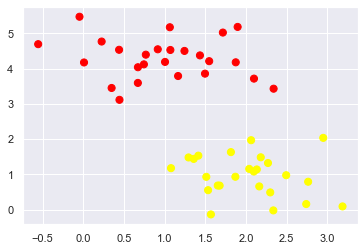

In [7]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

(-1.0, 3.5)

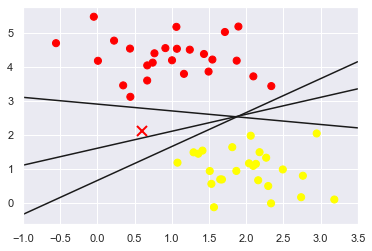

In [9]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point wil lbe assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.